In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Helper function for initial price based analysis
def conv_num(x, col):
    
    new_str = []
    
    if isinstance(x[col], str):
        
        for s in x[col][1:]:
            if s!=',':
                new_str.append(s)

        new_str = ''.join(new_str)
    
        return float(new_str)
    else:
        return x[col]

def load_data(city):

    df1 = pd.read_csv('{}_airbnb/calendar.csv'.format(city))
    df2 = pd.read_csv('{}_airbnb/listings.csv'.format(city))
    df2['listing_id'] = df2['id']
    
    df = pd.merge(df1, df2, on='listing_id', how='outer', indicator=True)
    df['date_calendar_month'] = pd.DatetimeIndex(df['date']).month
    
    df['price_calendar_num'] = df.parallel_apply(conv_num, args=('price_x',), axis=1)
    df['price_listings_num'] = df.parallel_apply(conv_num, args=('price_y',), axis=1)
    df.loc[df['available']=='t', 'available_num'] = 1.0
    df.loc[df['available']=='f', 'available_num'] = 0.0
    
    return df, df2
    

In [4]:
df1.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [5]:
df2.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [6]:
df3.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

# Price based analysis

In [6]:
list_cities=['seattle', 'boston']
df_dict = dict()
df_listings = dict()

for city in list_cities:

    df_dict[city], df_listings[city] = load_data(city)
    df = df_dict[city]

    null_tot = df[df['price_x'].isnull()].shape[0]
    
    null_not_avail = df[(df['price_x'].isnull()) & (df['available']=='f')].shape[0]
    
    assert null_tot==null_not_avail

1393570
459028
459028


1308890
665853
665853


# Price vs availability

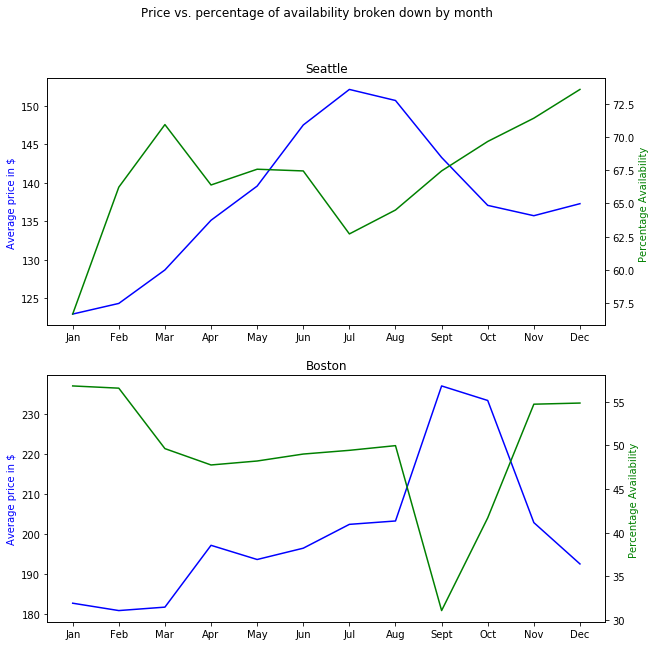

In [137]:


months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ax = dict()
fig,(ax[0],ax[1]) = plt.subplots(2,1, figsize=(10,10))
fig.suptitle('Price vs. percentage of availability broken down by month')
for ix, city in enumerate(list_cities):
    df = df_dict[city]

    
    ax[ix].set_title(city[0].upper() + city[1:])
    ax[ix].plot(months, df.groupby(['date_calendar_month'])['price_calendar_num'].mean(), color='blue')
    ax[ix].set_ylabel('Average price in $', color='blue')

    ax2=ax[ix].twinx()
    ax2.plot(months, df.groupby(['date_calendar_month'])['available_num'].mean()*100, color='green')
    ax2.set_ylabel('Percentage Availability ', color='green')

fig.savefig('price_avail_comp.png')




# Price vs review ratings

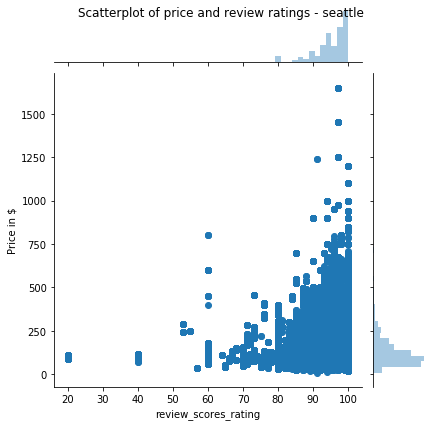

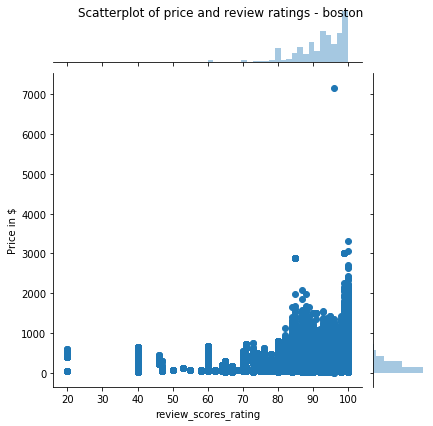

In [130]:

for ix, city in enumerate(list_cities):
    df = df_dict[city]

    f = sns.jointplot(df['review_scores_rating'], df['price_calendar_num'], kind='scatter')
    f.ax_joint.set_ylabel('Price in $')
    f.fig.suptitle('Scatterplot of price and review ratings - {}'.format(city))

    f.savefig('price_review_scatter_{}.png'.format(city))

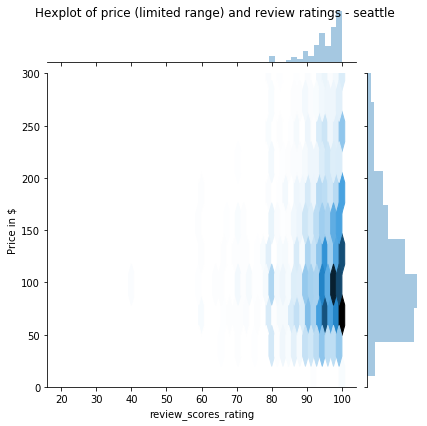

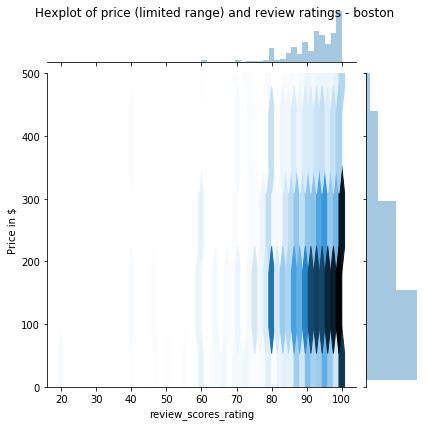

In [139]:
for ix, city in enumerate(list_cities):
    df = df_dict[city]

    f = sns.jointplot(df['review_scores_rating'], df['price_calendar_num'], kind='hex')
    if city=='seattle':
        plt.ylim(0, 300)
    else:
        plt.ylim(0, 500)
    f.ax_joint.set_ylabel('Price in $')
    f.fig.suptitle('Hexplot of price (limited range) and review ratings - {}'.format(city))

    f.savefig('price_review_hex_{}.png'.format(city))



# Superhost classification

In [125]:
# Pick which city
city = 'boston'
df2 = pd.read_csv('{}_airbnb/listings.csv'.format(city))

## Feature preprocessing

In [126]:
print(df2.shape)
df2.dropna(subset=['host_is_superhost'], how='any', inplace=True)
print(df2.shape)

df2.loc[df2['host_is_superhost']=='f', 'superhost'] = 0.0
df2.loc[df2['host_is_superhost']=='t', 'superhost'] = 1.0

# Convert host since to years in float
df2['host_since_diff'] = (pd.to_datetime(min(df_dict['seattle']['date'])) - pd.to_datetime(df2['host_since'])) / np.timedelta64(1, 'Y')

df2 = pd.get_dummies(df2, prefix='response_time', columns=['host_response_time'], dummy_na=True)

# Function to convert string with '%' to float
def conv_resp_rate(x, col):
    
    new_str = []
    
    if not isinstance(x[col], str) and math.isnan(x[col]):
        return -1.0
    
    for s in x['host_response_rate']:
        if s!='%':
            new_str.append(s)

    new_str = ''.join(new_str)

    return float(new_str) / 100.0
    
# Convert host response rate to float value between 0-1
df2['host_response_rate_num'] = df2.parallel_apply(conv_resp_rate, args=('host_response_rate',), axis=1)

if city=='boston':
    df2['acceptance_rate'] = df2.parallel_apply(conv_resp_rate, args=('host_acceptance_rate',), axis=1)
elif city=='seattle':
    df2 = pd.get_dummies(df2, prefix='accept', columns=['host_acceptance_rate'], dummy_na=True)

df2.loc[df2['host_listings_count']==1, 'multiple_listings'] = 0.0
df2.loc[df2['host_listings_count']>1, 'multiple_listings'] = 1.0

df2.loc[df2['host_identity_verified']=='f', 'host_id_ver'] = 0.0
df2.loc[df2['host_identity_verified']=='t', 'host_id_ver'] = 1.0

df2.loc[df2['is_location_exact']=='f', 'loc_exact'] = 0.0
df2.loc[df2['is_location_exact']=='t', 'loc_exact'] = 1.0


df2['cleaning_fee_num'] = df2.parallel_apply(conv_num, args=('cleaning_fee',), axis=1)
df2.loc[(df2['cleaning_fee_num'].isnull()) & (df2['host_is_superhost']=='t'), 'cleaning_fee_num'] = np.mean(df2[df2['host_is_superhost']=='t']['cleaning_fee_num'])
df2.loc[(df2['cleaning_fee_num'].isnull()) & (df2['host_is_superhost']=='f'), 'cleaning_fee_num'] = np.mean(df2[df2['host_is_superhost']=='f']['cleaning_fee_num'])

df2 = pd.get_dummies(df2, prefix='cancellation_policy', columns=['cancellation_policy'], dummy_na=True)

df2.loc[df2['instant_bookable']=='f', 'inst_book'] = 0.0
df2.loc[df2['instant_bookable']=='t', 'inst_book'] = 1.0

(3585, 95)
(3585, 95)


In [128]:
if city=='boston':
    get_cols = ['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', \
                'loc_exact', 'cleaning_fee_num', 'inst_book', 'acceptance_rate']

    for col in df2.columns:
        if 'response_time_' in col or 'cancellation_policy_' in col:
            get_cols.append(col)
elif city=='seattle':
    get_cols = ['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', \
                'loc_exact', 'cleaning_fee_num', 'inst_book']

    for col in df2.columns:
        if 'response_time_' in col or 'cancellation_policy_' in col or 'accept_' in col:
            get_cols.append(col)

print(get_cols)

['host_since_diff', 'host_response_rate_num', 'multiple_listings', 'host_id_ver', 'loc_exact', 'cleaning_fee_num', 'inst_book', 'acceptance_rate', 'response_time_a few days or more', 'response_time_within a day', 'response_time_within a few hours', 'response_time_within an hour', 'response_time_nan', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', 'cancellation_policy_super_strict_30', 'cancellation_policy_nan']


## Train and predict classifier

In [129]:
#gb = GradientBoostingClassifier(n_estimators=200, max_depth=4)
gb = XGBClassifier(n_estimators=200, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(df2[get_cols], df2['superhost'], test_size=0.33, random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())

gb.fit(X_train, y_train)
preds = gb.predict(X_test)

print(len(preds), sum(preds==y_test))

print(sum(y_test[y_test==1]==preds[y_test==1]))

print(sum(y_test[y_test==0]==preds[y_test==0]))

0.0    2119
1.0     282
Name: superhost, dtype: int64
0.0    1059
1.0     125
Name: superhost, dtype: int64
1184 1110
70
1040


## Get feature importances

In [121]:
imps = gb.feature_importances_
imps_ix = np.argsort(imps)
imps_ix = imps_ix[::-1]
print(imps)
imps_ord = []
coefs = []
for ix in imps_ix:
    imps_ord.append(get_cols[ix])
    coefs.append(imps[ix])

[0.04973413 0.20099376 0.04426772 0.13301958 0.05167777 0.13174947
 0.04905096 0.         0.         0.07492304 0.07427429 0.04571762
 0.         0.05659302 0.03803786 0.04996077 0.         0.        ]


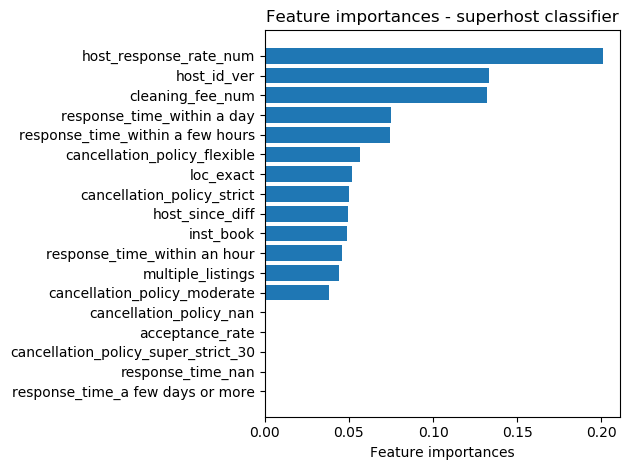

In [122]:

y_pos = np.arange(len(imps_ix))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos, coefs, align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(imps_ord)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importances')
ax.set_title('Feature importances - superhost classifier')

plt.tight_layout()
fig.savefig('superhost_boston.png')